# Topic Discovery Using Latent Dirichlet Algorithm (LDA) And Coming up With Optimal Number Of Topics

LDA is an unsupervised algorithm which requires the number of topics to be defined beforehand. We can have as many topics as we want. However, a high amount of topics would be too specific, likewise fewer topics would be too generalized. Thankfully, a form of measurement comes into play at this stage to evaluate our model. 

### Evaluation of the Model

Gensim presents the convenience of calculating "Perplexity" and "Coherence" of models. Perplexity is a statical measure of how well a probability model predicts a sample. And Coherence value is the degree of semantic similarity between high scoring words in the topic. Studies have shown that optimizing for perplexity may not yield human interpretable topics. So in this model, i went for the highest coherence before the coherence-n_topics graph kind of stabilizes. (https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)

But how do we know the amount of topics we should go for? This can of course be done by trial and error. Below is a method called compute_coherence_values is utilized to run the created LDA model several times in a for loop, each time changing the amount of topics by predefined boundaries and step size. After the models are tested (which takes a good couple of hours), the program plots the models with different topic sizes with their respective coherence scores.

### Pre-processing

Now the next question is, how to ensure a high coherence score? Like every other machine learning model, its success comes out of its quality. If we humans deduct and make predictions based on our past experiences, a ML model has its training set as its comprehension of world around it. The model here goes through pre-processing with several steps. These are getting rid of stopwords (the most common words that can appear in any document and add little to no meaning), punctuations, upper case and non-english letters. Then each word in our corpus (entire collection of texts) is lemmatized and stemmed to be reduced in their singular and base forms. Any token (word) shorter than 3 letters are removed. So are the documents outside the range of 4 and 40 words in total. Remaining corpus is checked for bigrams to merge the sets of words that appear in corpus more than 10 times. Lastly, any token that appears more than %70 of the documents and less than 20 of the documents are removed.

### LDA Model

Bag of words in preprocessed corpus is casted into a tf_idf model which reflects how important and defining a word is in a corpus. Mainly, if a word appears more in a document and less in other documents, it bears high information for the document it appears a lot. We will feed this corpus and our dictionary to our model. Reaching to training phase, we come across many parameters waiting to be tuned. I tried to experiment with the parameters "chunksize, passes, iterations, eta.." The best coherence i could get was around 0.48. Gensim allow Mallet wrapper for LDA, which is a Java based module for NLP and yields better results. However, i didn't implement it in this project. 

### Visualization

A very useful Python version of visualization package for R language is used to see how well the topics were doing. We can see clusters of relevant topics overlapping whereas distinct topics are standing far from the other ones.

#### Below topic probably is about cleaning of the product, how it should be washed or shouldn'r
(11,
  '0.013*"wash" + 0.009*"dri" + 0.008*"dri_clean" + 0.008*"shrunk" + 0.008*"hand_wash" + 0.007*"shrink" + 0.007*"great" + 0.007*"dryer" + 0.006*"love" + 0.006*"say"')

#### And this topic is probably named Jeans since it is mostly defined by the words 'jean' and 'pant'. It also has words 'pair', 'denim' and 'pilcro'
(2,
  '0.015*"jean" + 0.012*"pant" + 0.009*"vest" + 0.008*"pair" + 0.008*"love" + 0.008*"great" + 0.008*"fit" + 0.007*"pilcro" + 0.007*"wear" + 0.007*"denim"')
  
## TO-DO

Although i get a result from the model, coherence score and the distrubition of the topics are not satisfying. I believe a better pre-processing where some addition to stopwords and a different lemmatizer which maybe excludes adjectives can yield better result. The same goes for criteria to create bigrams off the words. Also, model can use more tuning.

In [58]:
import pandas as pd
import pyLDAvis.gensim
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from gensim import models, corpora
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

In [59]:
def preprocessing(rev):
    result = []
    ps = PorterStemmer()
    wnl = WordNetLemmatizer()

    [result.append(ps.stem(wnl.lemmatize(token))) for token in simple_preprocess(rev, min_len=3) if token not in STOPWORDS]
    
    return result

In [60]:
def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

In [61]:
# LOAD DATA

data = pd.read_csv('reviews.csv')
data.dropna(axis=0,how='any',inplace=True)

reviews = [txt for txt in data['Review Text']]

# PREPROCESSING

docs = [preprocessing(rev) for rev in reviews]

In [62]:
# Make Bigrams

bigram = models.Phrases(docs,min_count=10,threshold=6)
bigram_phraser = models.phrases.Phraser(bigram)

bigramed_data = make_bigrams(docs)
docs = bigramed_data

In [63]:
chosen_docs = []
for doc in docs:
    if len(doc) > 4 and len(doc) < 40:
        chosen_docs.append(doc)

docs = chosen_docs

In [64]:
dictionary = corpora.Dictionary(docs)
dictionary.filter_extremes(no_below=20,no_above=0.7)
dictionary.compactify

bag_corpus = [dictionary.doc2bow(rev) for rev in docs]

In [65]:
tf_idf = models.TfidfModel(bag_corpus)
corpus_tfidf = tf_idf[bag_corpus]

In [72]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, chunksize=20000, passes=50, iterations=30, eval_every=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

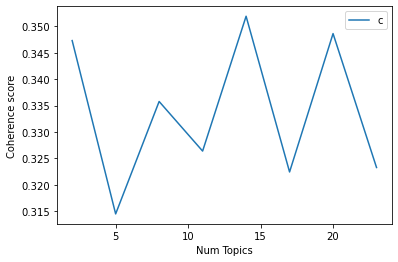

In [73]:
# Try out the model for a range of number of topics and display the coherence values

model_list, coherence_values = compute_coherence_values(dictionary=dictionary,
                                                       corpus=corpus_tfidf,
                                                       texts=docs,
                                                       start=2,
                                                       limit=26,
                                                       step=3)

limit=26; start=2; step=3;
x = range(start,limit,step)
plt.plot(x,coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"),loc='best')
plt.show()

In [74]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, "has coherence value of", round(cv,4))

Num Topics = 2 has coherence value of 0.3473
Num Topics = 5 has coherence value of 0.3145
Num Topics = 8 has coherence value of 0.3358
Num Topics = 11 has coherence value of 0.3264
Num Topics = 14 has coherence value of 0.3519
Num Topics = 17 has coherence value of 0.3224
Num Topics = 20 has coherence value of 0.3486
Num Topics = 23 has coherence value of 0.3233


In [11]:
# The lower the perplexity and the higher the coherence, the better

print('\nPerplexity: ', model_list[4].log_perplexity(corpus_tfidf,len(docs)))

coherence_model_lda = CoherenceModel(model=model_list[16], texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.811724845573295

Coherence Score:  0.4690177299334415


In [76]:
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.015*"size" + 0.012*"order" + 0.011*"dress" + 0.011*"small" + 0.010*"petit" + 0.010*"larg" + 0.009*"medium" + 0.009*"big" + 0.008*"like" + 0.008*"look"'),
 (1,
  '0.014*"color" + 0.009*"love" + 0.008*"dress" + 0.007*"white" + 0.007*"beauti" + 0.007*"shirt" + 0.007*"great" + 0.007*"blue" + 0.007*"red" + 0.007*"yellow"'),
 (2,
  '0.015*"jean" + 0.012*"pant" + 0.009*"vest" + 0.008*"pair" + 0.008*"love" + 0.008*"great" + 0.008*"fit" + 0.007*"pilcro" + 0.007*"wear" + 0.007*"denim"'),
 (3,
  '0.009*"dress" + 0.008*"skirt" + 0.008*"color" + 0.007*"love" + 0.007*"nice" + 0.007*"great" + 0.007*"fabric" + 0.007*"look" + 0.007*"like" + 0.006*"fit"'),
 (4,
  '0.017*"dress" + 0.007*"love" + 0.007*"beauti" + 0.007*"fit" + 0.007*"flatter" + 0.007*"perfect" + 0.007*"wear" + 0.006*"belt" + 0.006*"great" + 0.006*"size"'),
 (5,
  '0.014*"pant" + 0.012*"wash" + 0.008*"bought" + 0.008*"stretch" + 0.008*"hole" + 0.007*"love" + 0.007*"wear" + 0.007*"pair" + 0.007*"fit" + 0.007*"time"'),
 (6,
  '0.01

In [77]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(optimal_model, corpus_tfidf, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.094214  0.040378       1        1  14.302550
6      0.097804  0.015962       2        1  11.903751
0      0.096243  0.055377       3        1  10.420798
13     0.047689  0.019478       4        1   7.667683
9     -0.091885 -0.002572       5        1   7.170087
2     -0.037332 -0.038044       6        1   6.914097
3     -0.008890  0.047307       7        1   6.909132
1     -0.028122  0.051892       8        1   6.813499
4     -0.002768  0.051155       9        1   5.526044
8     -0.134643 -0.002338      10        1   5.253656
7     -0.056683  0.020699      11        1   4.923705
12    -0.053349  0.007080      12        1   4.219961
5      0.028969 -0.149798      13        1   4.170004
11     0.048753 -0.116576      14        1   3.805033, topic_info=      Term        Freq       Total Category  logprob  loglift
392   wash  139.000000  139.000000  Default  30.0000  30.0000
79    pant  270.000000  270.000000  Default  29.0000  29.0000
204   jean  269.000000  269.000000  Default  28.0000  28.0000
33   great  487.000000  487.000000  Default  27.0000  27.0000
43    pair  171.000000  171.000000  Default  26.0000  26.0000
..     ...         ...         ...      ...      ...      ...
15   order   12.391140  389.439079  Topic14  -5.4100  -0.1789
243   cute   11.957142  311.752507  Topic14  -5.4456   0.0080
45   shirt   11.531333  363.614974  Topic14  -5.4819  -0.1822
163   like   11.505797  439.973536  Topic14  -5.4841  -0.3750
326    got   11.181173  255.805869  Topic14  -5.5127   0.1387

[986 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
907       3  0.073833  absolut_ador
907       4  0.590663  absolut_ador
907       6  0.073833  absolut_ador
907      11  0.073833  absolut_ador
907      12  0.073833  absolut_ador
...     ...       ...           ...
28        8  0.029637        zipper
28        9  0.044456        zipper
28       11  0.014819        zipper
28       13  0.059275        zipper
28       14  0.074093        zipper

[4019 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 7, 1, 14, 10, 3, 4, 2, 5, 9, 8, 13, 6, 12])